# 3D Gaussian Splatting on Fern Dataset

This notebook demonstrates training and rendering 3D Gaussians on the LLFF Fern scene.

In [1]:
import sys
from pathlib import Path
import torch
import numpy as np
import random
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

! pip install ipywidgets

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from gsplat.datasets import ColmapDataset
from gsplat.methods.original import OriginalGaussianSplat
from gsplat.utils import set_global_seed

set_global_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.4 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'gsplat'

In [2]:
# Load dataset
colmap_path = project_root / "gsplat/datasets/nerf_llff_data/fern/sparse/0"
images_path = project_root / "gsplat/datasets/nerf_llff_data/fern/images_4"

dataset = ColmapDataset(colmap_path=colmap_path, images_path=images_path, device=device)
print(f"Loaded {len(dataset)} images, {len(dataset.get_points3d())} 3D points")

Notice: Could not find IMG_4026.JPG in /Users/khyledhanani/Documents/Fun-Gaussian-Splats/gsplat/datasets/nerf_llff_data/fern/images_4
Attempting to match images by sorted order...
Success: Matched 20 images by sorted order.
Loaded 20 images, 10091 3D points


In [3]:
# Initialize method
config = {
    "device": device,
    "lr_means": 0.00016,
    "lr_rotations": 0.001,
    "lr_scales": 0.005,
    "lr_sh_coeffs": 0.0025,
    "lr_opacities": 0.05,
    "gaussian": {"initial_scale": 0.01, "sh_degree": 0},
}

method = OriginalGaussianSplat(config)
method.load_cameras_from_dataset(dataset)
method.create_primitives(dataset.get_points3d())
method.setup_optimizer()
print(f"Initialized with {method.means.shape[0]} Gaussians")

Initializing OriginalGaussianSplat with config: {'device': 'cpu', 'lr_means': 0.00016, 'lr_rotations': 0.001, 'lr_scales': 0.005, 'lr_sh_coeffs': 0.0025, 'lr_opacities': 0.05, 'gaussian': {'initial_scale': 0.01, 'sh_degree': 0}}
Loaded 20 cameras and 20 images from dataset
Creating 10091 primitives from COLMAP 3D points


Creating primitives:   0%|          | 0/10091 [00:00<?, ?it/s]

Setting up optimizer
Initialized with 10091 Gaussians


In [4]:
# Helper functions
def load_image_tensor(path, device="cpu"):
    img = PILImage.open(path).convert("RGB")
    return torch.from_numpy(np.array(img).astype(np.float32) / 255.0).to(device)

def tensor_to_image(tensor):
    return np.clip(tensor.detach().cpu().numpy(), 0, 1)

def compute_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse)).item() if mse > 0 else float('inf')

In [5]:
# Training loop
num_steps = 1000
losses = []

for step in tqdm(range(num_steps)):
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]
    target = load_image_tensor(sample["image_path"], device=device)
    
    batch = {"camera": sample["camera"], "target_image": target}
    result = method.train_step(batch, iter_pct=step / num_steps)
    losses.append(result["loss"])
    
    if step % 50 == 0:
        print(f"Step {step}: Loss = {result['loss']:.6f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0: Loss = 0.322374
Step 50: Loss = 0.340949
Step 100: Loss = 0.323229
Step 150: Loss = 0.300015
Step 200: Loss = 0.295128
Step 250: Loss = 0.248068
Step 300: Loss = 0.201518
Step 350: Loss = 0.116653
Step 400: Loss = 0.069011
Step 450: Loss = 0.038534
Setting up optimizer
Step 500: Gaussians: 10091 -> 15185 (Split: 4725, Clone: 424, Pruned: 4780)
Step 500: Loss = 0.043547
Step 550: Loss = 0.035746
Setting up optimizer
Step 600: Gaussians: 15185 -> 17993 (Split: 2954, Clone: 146, Pruned: 3246)
Step 600: Loss = 0.042180
Step 650: Loss = 0.039458
Setting up optimizer
Step 700: Gaussians: 17993 -> 22108 (Split: 4077, Clone: 206, Pruned: 4245)
Step 700: Loss = 0.048435
Step 750: Loss = 0.037979
Setting up optimizer
Step 800: Gaussians: 22108 -> 26624 (Split: 4423, Clone: 173, Pruned: 4503)
Step 800: Loss = 0.065231
Step 850: Loss = 0.029047
Setting up optimizer
Step 900: Gaussians: 26624 -> 30806 (Split: 4204, Clone: 110, Pruned: 4336)
Step 900: Loss = 0.049686
Step 950: Loss = 0.03584

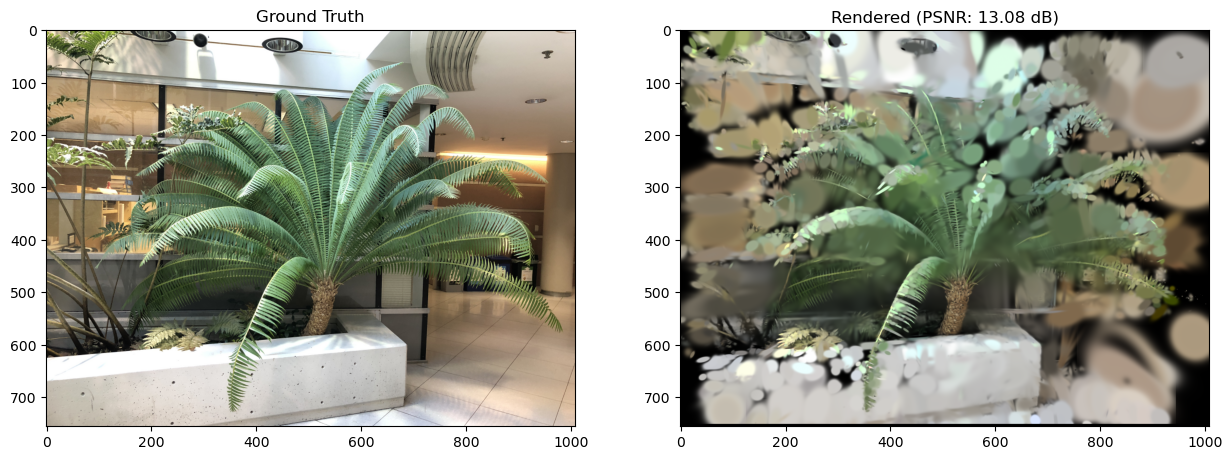

In [6]:
# Render test view
test_sample = dataset[0]
with torch.no_grad():
    output = method.render(test_sample["camera"])
    rendered = output["image"]

gt = load_image_tensor(test_sample["image_path"], device=device)
psnr = compute_psnr(rendered, gt)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(tensor_to_image(gt))
axes[0].set_title('Ground Truth')
axes[1].imshow(tensor_to_image(rendered))
axes[1].set_title(f'Rendered (PSNR: {psnr:.2f} dB)')
plt.show()